In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DATA_DIR = "/Users/mgrsuraz/Downloads/Courses/DSDE/Project_Final/Health_project/processed_data/"

# Obesity

In [2]:
def load_parquet_obesity():
    path = os.path.join(DATA_DIR, "obesity_all_years.parquet")
    print("Loading:", path)
    df = pd.read_parquet(path)
    return df

obesity = load_parquet_obesity()
obesity.head()


Loading: /Users/mgrsuraz/Downloads/Courses/DSDE/Project_Final/Health_project/processed_data/obesity_all_years.parquet


,year,stateabbr,statedesc,locationname,measureid,obesity_rate,totalpopulation,latitude,longitude,data_value_type
0,2023,MO,Missouri,Stone,OBESITY,41.1,32658,36.746958,-93.455977,Age-adjusted prevalence
1,2023,MT,Montana,Sweet Grass,OBESITY,29.7,3763,45.814737,-109.940541,Age-adjusted prevalence
2,2023,MO,Missouri,Pulaski,OBESITY,35.8,53812,37.824651,-92.207673,Crude prevalence
3,2023,MO,Missouri,St. Charles,OBESITY,35.7,416659,38.781939,-90.674260,Crude prevalence
4,2023,NE,Nebraska,Furnas,OBESITY,44.4,4556,40.176463,-99.912493,Crude prevalence


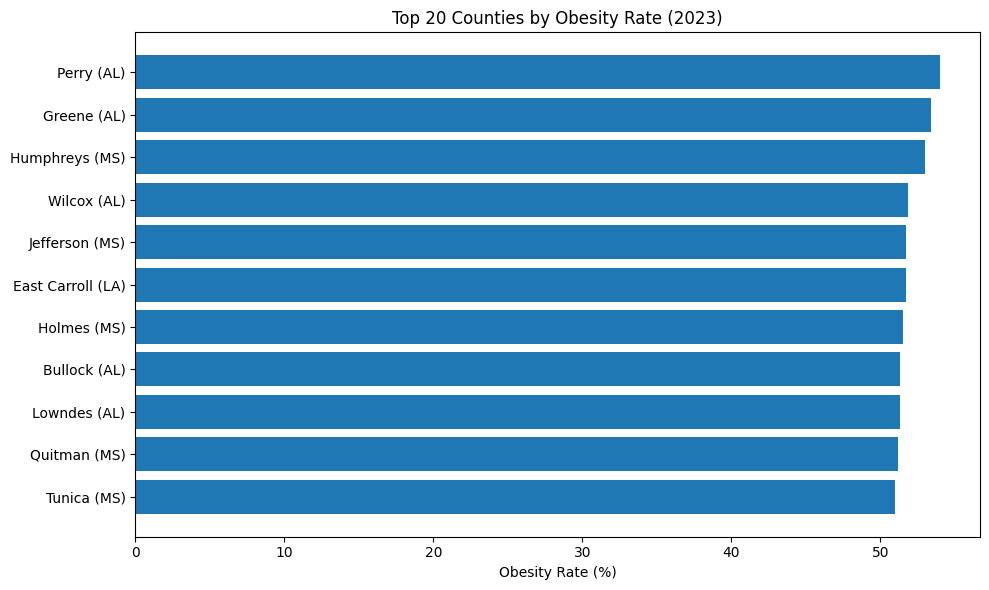

In [3]:
# Use the latest year available
latest_year = obesity["year"].max()
latest_df = obesity[obesity["year"] == latest_year]

top20 = (
    latest_df
    .sort_values("obesity_rate", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
plt.barh(top20["locationname"] + " (" + top20["stateabbr"] + ")", top20["obesity_rate"])
plt.gca().invert_yaxis()
plt.xlabel("Obesity Rate (%)")
plt.title(f"Top 20 Counties by Obesity Rate ({latest_year})")
plt.tight_layout()
plt.show()


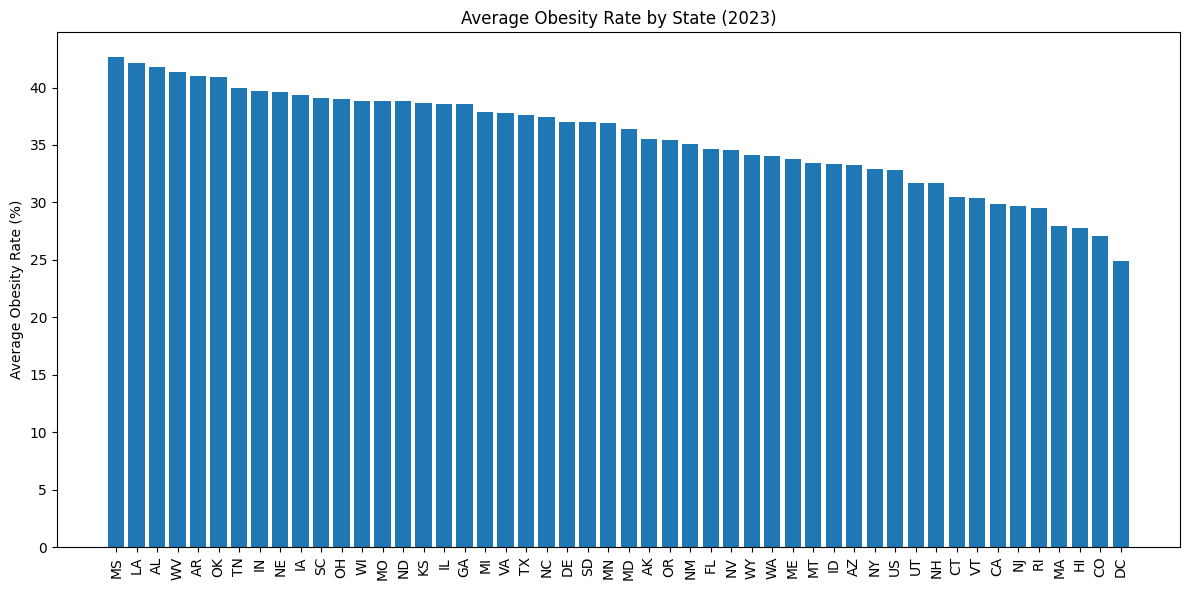

In [4]:
state_avg = (
    latest_df
    .groupby(["stateabbr", "statedesc"], as_index=False)
    .agg(
        mean_obesity=("obesity_rate", "mean"),
        pop=("totalpopulation", "sum")
    )
)

state_avg_sorted = state_avg.sort_values("mean_obesity", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(state_avg_sorted["stateabbr"], state_avg_sorted["mean_obesity"])
plt.xticks(rotation=90)
plt.ylabel("Average Obesity Rate (%)")
plt.title(f"Average Obesity Rate by State ({latest_year})")
plt.tight_layout()
plt.show()


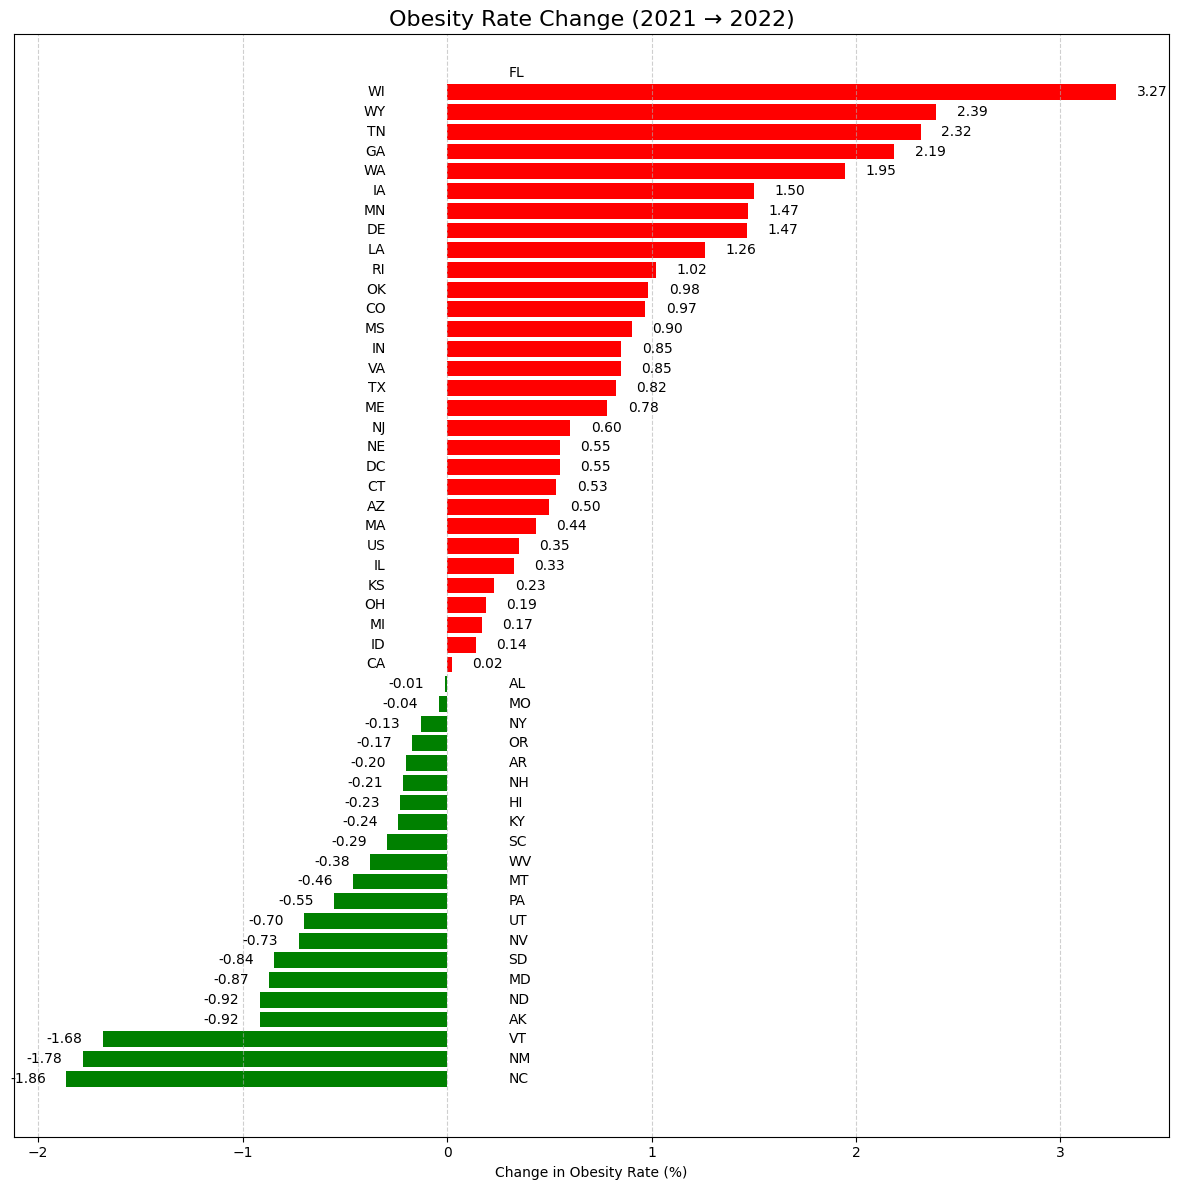

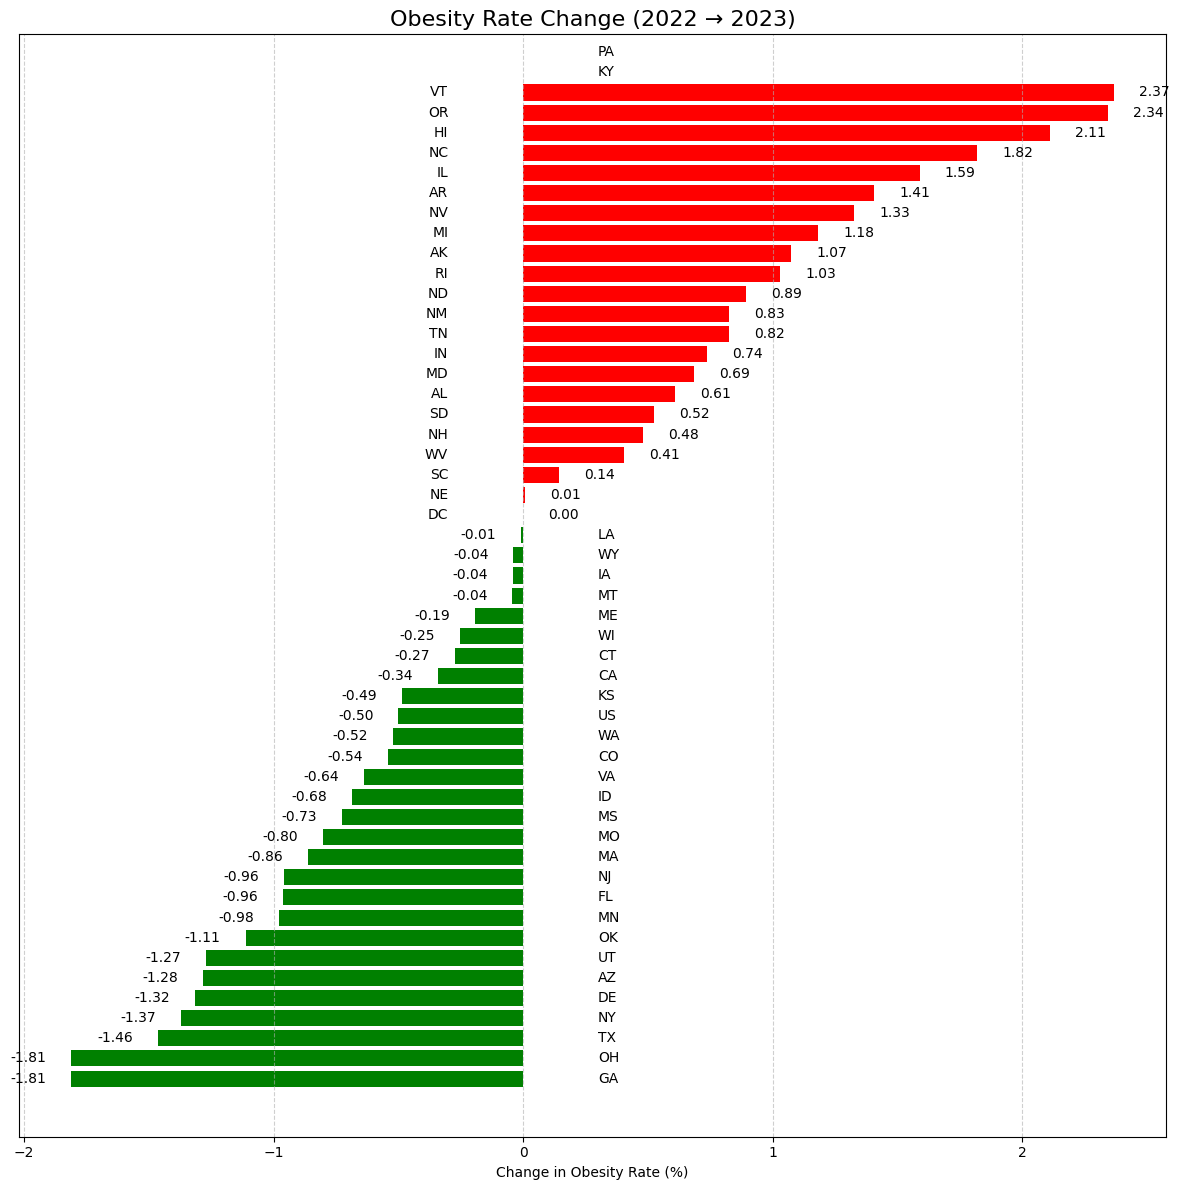

In [15]:
# Obesity change per state (2021 to 2023)

# Filter obesity only
ob = obesity[obesity["measureid"] == "OBESITY"]

# Compute average obesity per state per year
state_year_avg = (
    ob.groupby(["stateabbr", "year"])["obesity_rate"]
      .mean()
      .reset_index()
)

# Pivot into wide format
state_pivot = state_year_avg.pivot(
    index="stateabbr",
    columns="year",
    values="obesity_rate"
).reset_index()

state_pivot.head()

state_pivot["change_2021_2022"] = state_pivot[2022] - state_pivot[2021]
state_pivot["change_2022_2023"] = state_pivot[2023] - state_pivot[2022]

import matplotlib.pyplot as plt
import numpy as np

def plot_change(df, col, title):
    df_sorted = df.sort_values(col)
    values = df_sorted[col].values
    states = df_sorted["stateabbr"].values

    colors = np.where(values >= 0, "red", "green")

    plt.figure(figsize=(12,12))
    bars = plt.barh(
        range(len(values)),
        values,
        color=colors
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel("Change in Obesity Rate (%)")
    plt.yticks([])  # remove axis labels
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    # Place State Abbr
    for i, (v, st) in enumerate(zip(values, states)):
        
        if v >= 0:
            # positive bar: put state on left side of bar start
            plt.text(
                0 - 0.3,      
                i,
                st,
                va="center",
                ha="right",
                fontsize=10,
            )
        else:
            # negative bar: put state on right side of zero line
            plt.text(
                0 + 0.3,
                i,
                st,
                va="center",
                ha="left",
                fontsize=10,
                # fontweight="bold"
            )

        # Place CHANGE VALUE 
        plt.text(
            v + (0.1 if v >= 0 else -0.1), 
            i,
            f"{v:.2f}", 
            va="center",
            ha="left" if v >= 0 else "right",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


plot_change(state_pivot, "change_2021_2022", "Obesity Rate Change (2021 → 2022)")
plot_change(state_pivot, "change_2022_2023", "Obesity Rate Change (2022 → 2023)")



/var/folders/nw/57_fjtfx1n3515btxc1rjzyh0000gn/T/ipykernel_31480/1205067652.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_obesity["weighted_obesity"] = (


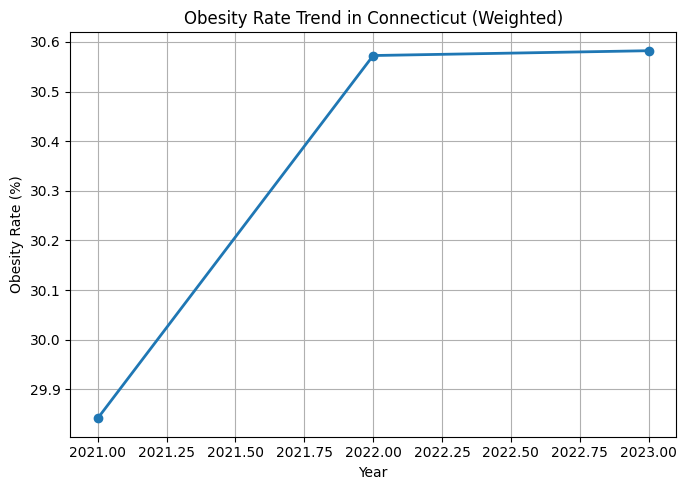

,year,total_weighted,total_pop,ct_obesity_rate
0,2021,215191356.1,7211194,29.841293
1,2022,221725463.9,7252410,30.572660
2,2023,221243590.0,7234352,30.582365


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for Connecticut + Obesity only
ct_obesity = obesity[
    (obesity["stateabbr"] == "CT") &
    (obesity["measureid"] == "OBESITY")
]

# Compute statewide population-weighted obesity per year
ct_obesity["weighted_obesity"] = (
    ct_obesity["obesity_rate"] * ct_obesity["totalpopulation"]
)

ct_trend = (
    ct_obesity.groupby("year", as_index=False)
    .agg(
        total_weighted=("weighted_obesity", "sum"),
        total_pop=("totalpopulation", "sum"),
    )
)

ct_trend["ct_obesity_rate"] = (
    ct_trend["total_weighted"] / ct_trend["total_pop"]
)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(
    ct_trend["year"], 
    ct_trend["ct_obesity_rate"], 
    marker="o", linewidth=2
)
plt.title("Obesity Rate Trend in Connecticut (Weighted)")
plt.xlabel("Year")
plt.ylabel("Obesity Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

ct_trend


In [17]:
# Find Which Connecticut County Has the Highest Obesity Rate

latest_year = obesity["year"].max()

ct_latest = obesity[
    (obesity["stateabbr"] == "CT") &
    (obesity["measureid"] == "OBESITY") &
    (obesity["year"] == latest_year)
]

highest_ct_county = ct_latest.sort_values(
    "obesity_rate", ascending=False
).head(1)

print("County with highest obesity in CT:")
print(highest_ct_county[["locationname", "obesity_rate", "totalpopulation"]])


County with highest obesity in CT:
                   locationname  obesity_rate  totalpopulation
8223  South Central Connecticut          33.9           568158


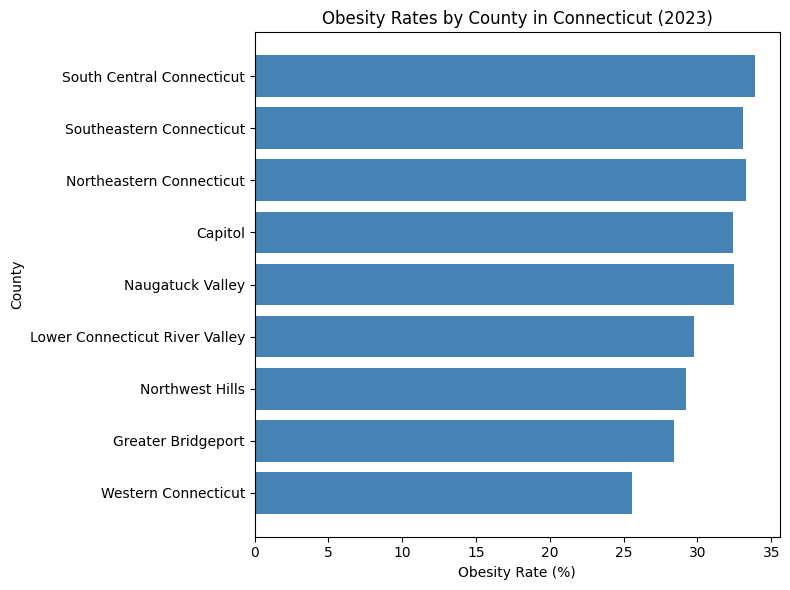

In [18]:
# CT Obesity by County

import matplotlib.pyplot as plt

latest_year = obesity["year"].max()

ct_latest = obesity[
    (obesity["stateabbr"] == "CT") &
    (obesity["measureid"] == "OBESITY") &
    (obesity["year"] == latest_year)
]

ct_latest_sorted = ct_latest.sort_values(
    "obesity_rate", ascending=True
)

plt.figure(figsize=(8,6))
plt.barh(
    ct_latest_sorted["locationname"],
    ct_latest_sorted["obesity_rate"],
    color="steelblue"
)
plt.title(f"Obesity Rates by County in Connecticut ({latest_year})")
plt.xlabel("Obesity Rate (%)")
plt.ylabel("County")
plt.tight_layout()
plt.show()


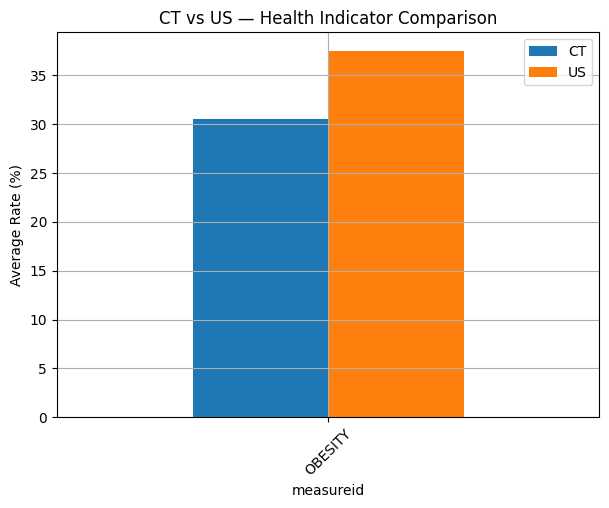

,CT,US
measureid,,
OBESITY,30.519231,37.541535


In [19]:
metrics = ["OBESITY", "DIABETES", "DEPRESSION"]

ct_metrics = obesity[
    (obesity["stateabbr"] == "CT") &
    (obesity["measureid"].isin(metrics))
].groupby("measureid")["obesity_rate"].mean()

us_metrics = obesity[
    (obesity["measureid"].isin(metrics))
].groupby("measureid")["obesity_rate"].mean()

df_compare = pd.DataFrame({
    "CT": ct_metrics,
    "US": us_metrics
})

df_compare.plot(kind="bar", figsize=(7,5))
plt.title("CT vs US — Health Indicator Comparison")
plt.ylabel("Average Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df_compare


# Diabetes

In [20]:
def load_parquet_diabetes():
    path = os.path.join(DATA_DIR, "diabetes_all_years.parquet")
    print("Loading:", path)
    df = pd.read_parquet(path)
    return df

diabetes = load_parquet_diabetes()
diabetes.head()

Loading: /Users/mgrsuraz/Downloads/Courses/DSDE/Project_Final/Health_project/processed_data/diabetes_all_years.parquet


,year,stateabbr,statedesc,locationname,measureid,diabetes_rate,totalpopulation,latitude,longitude,data_value_type
0,2023,MO,Missouri,Osage,DIABETES,11.2,13468,38.460051,-91.861603,Crude prevalence
1,2023,MT,Montana,Roosevelt,DIABETES,14.1,10319,48.294495,-105.016583,Crude prevalence
2,2023,MT,Montana,Deer Lodge,DIABETES,9.5,9673,46.060825,-113.066771,Age-adjusted prevalence
3,2023,MO,Missouri,Henry,DIABETES,11.0,22485,38.385278,-93.792863,Age-adjusted prevalence
4,2023,MO,Missouri,Stone,DIABETES,10.3,32658,36.746958,-93.455977,Age-adjusted prevalence


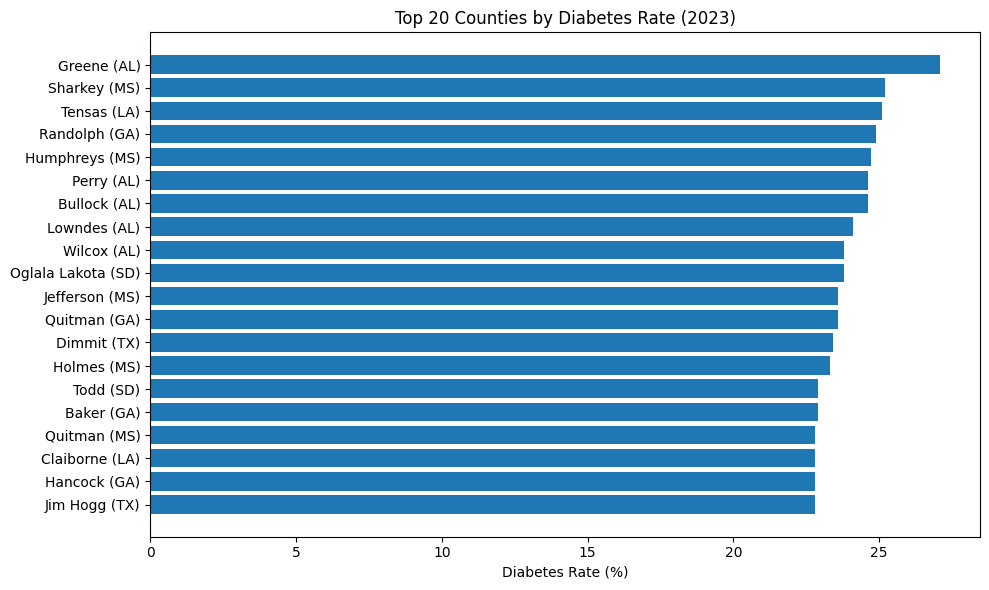

In [21]:
latest_year = diabetes["year"].max()
latest_df = diabetes[diabetes["year"] == latest_year]

top20 = (
    latest_df
    .sort_values("diabetes_rate", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
plt.barh(top20["locationname"] + " (" + top20["stateabbr"] + ")", top20["diabetes_rate"])
plt.gca().invert_yaxis()
plt.xlabel("Diabetes Rate (%)")
plt.title(f"Top 20 Counties by Diabetes Rate ({latest_year})")
plt.tight_layout()
plt.show()

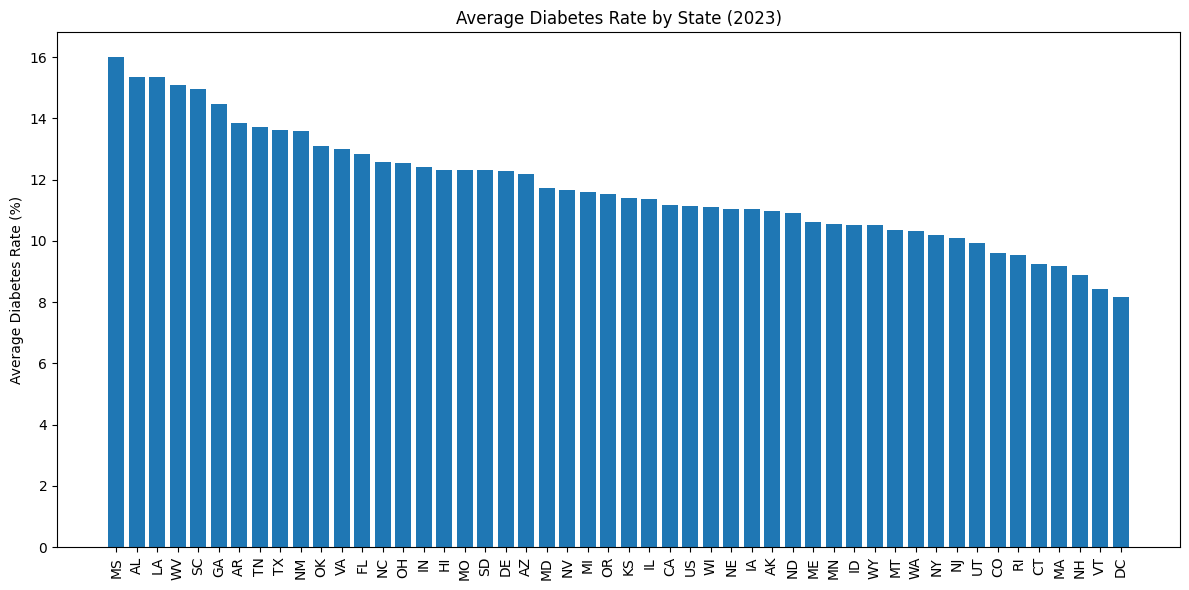

In [22]:
state_avg = (
    latest_df
    .groupby(["stateabbr", "statedesc"], as_index=False)
    .agg(
        mean_diabetes=("diabetes_rate", "mean"),
        pop=("totalpopulation", "sum")
    )
)

state_avg_sorted = state_avg.sort_values("mean_diabetes", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(state_avg_sorted["stateabbr"], state_avg_sorted["mean_diabetes"])
plt.xticks(rotation=90)
plt.ylabel("Average Diabetes Rate (%)")
plt.title(f"Average Diabetes Rate by State ({latest_year})")
plt.tight_layout()
plt.show()

/var/folders/nw/57_fjtfx1n3515btxc1rjzyh0000gn/T/ipykernel_31480/572266767.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_diabetes["weighted_diabetes"] = (


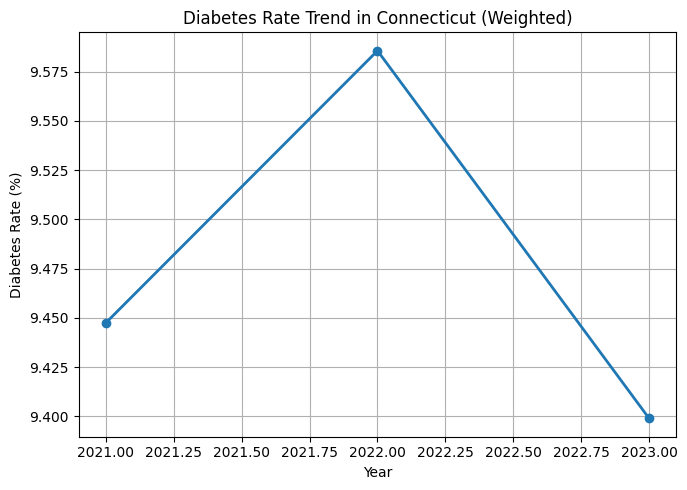

,year,total_weighted,total_pop,ct_diabetes_rate
0,2021,68128070.5,7211194,9.447544
1,2022,69518306.2,7252410,9.585546
2,2023,67996082.4,7234352,9.399056


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for Connecticut + diabetes only
ct_diabetes = diabetes[
    (diabetes["stateabbr"] == "CT") &
    (diabetes["measureid"] == "DIABETES")
]

# Compute statewide population-weighted diabetes per year
ct_diabetes["weighted_diabetes"] = (
    ct_diabetes["diabetes_rate"] * ct_diabetes["totalpopulation"]
)

ct_trend = (
    ct_diabetes.groupby("year", as_index=False)
    .agg(
        total_weighted=("weighted_diabetes", "sum"),
        total_pop=("totalpopulation", "sum"),
    )
)

ct_trend["ct_diabetes_rate"] = (
    ct_trend["total_weighted"] / ct_trend["total_pop"]
)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(
    ct_trend["year"], 
    ct_trend["ct_diabetes_rate"], 
    marker="o", linewidth=2
)
plt.title("Diabetes Rate Trend in Connecticut (Weighted)")
plt.xlabel("Year")
plt.ylabel("Diabetes Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

ct_trend

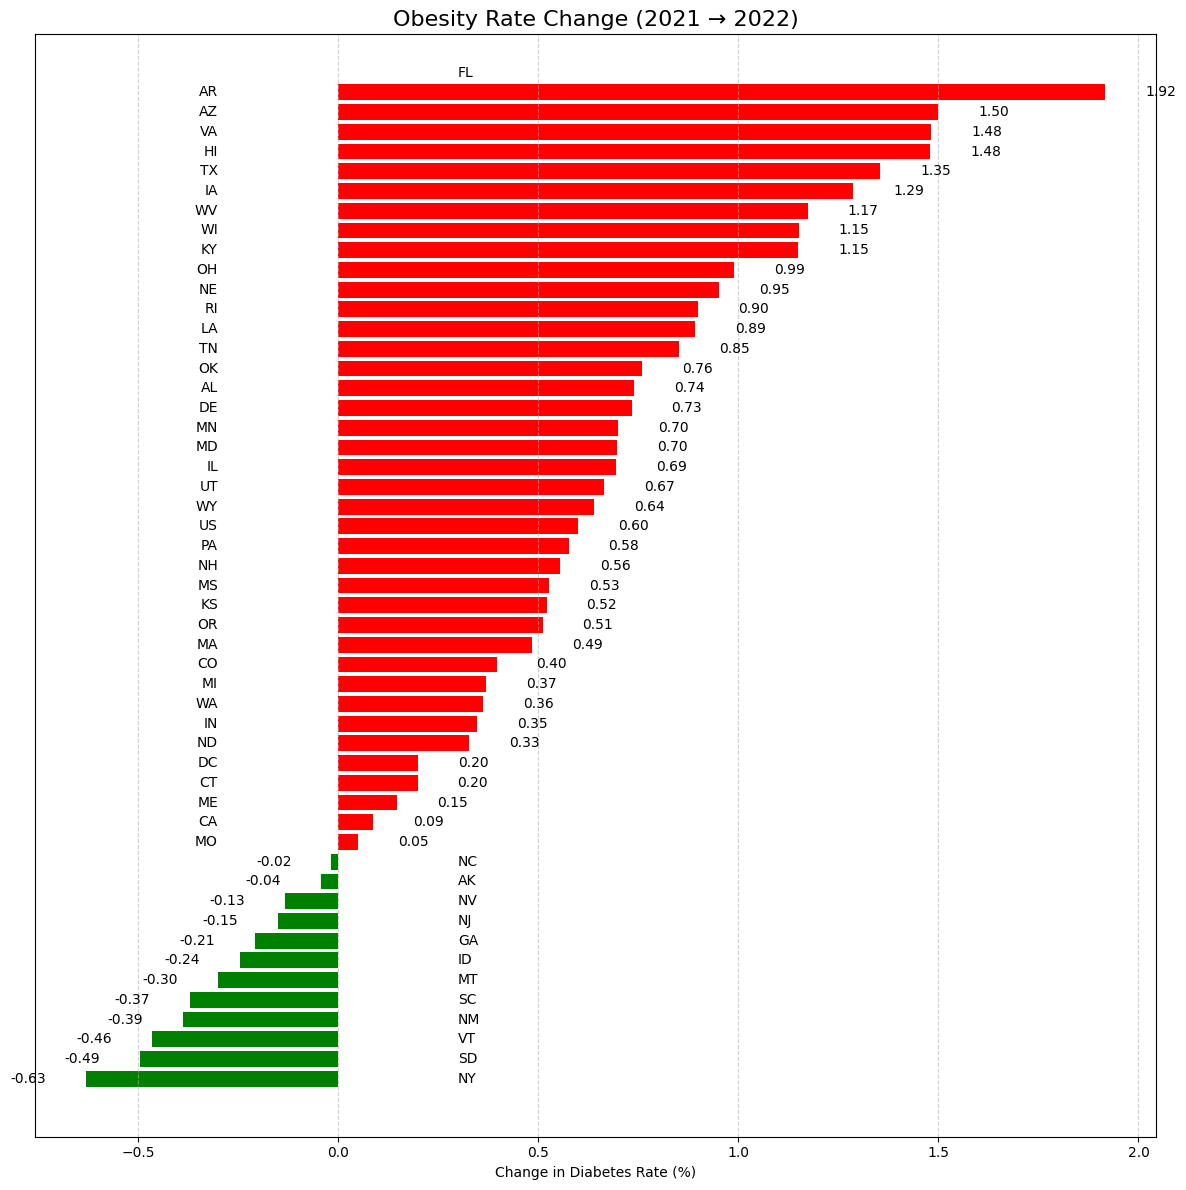

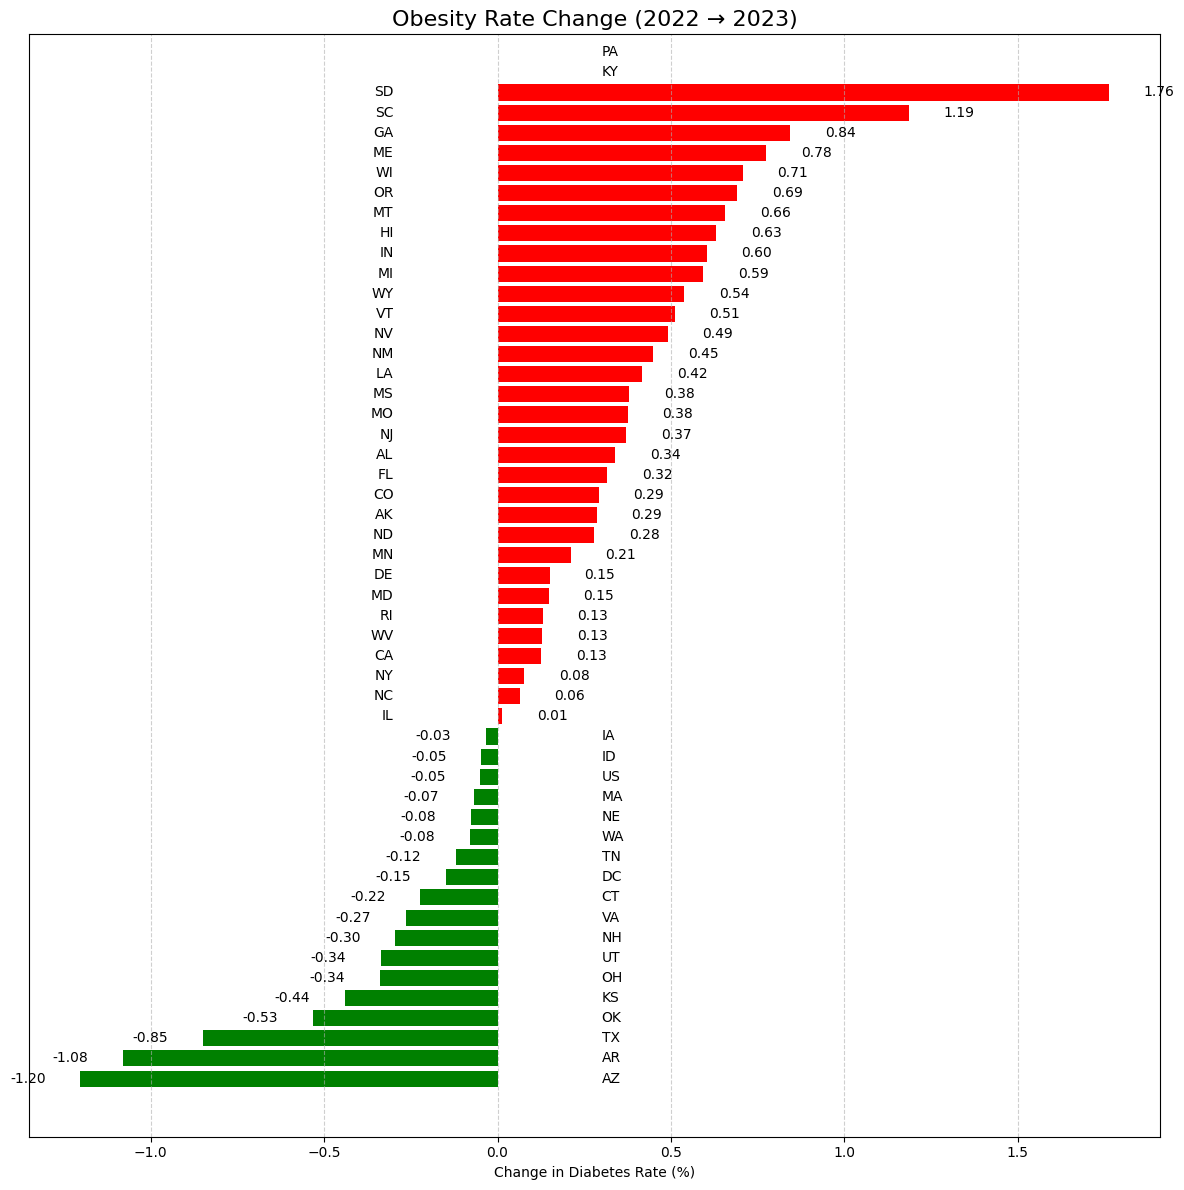

In [24]:
# Diabetes change per state (2021 to 2023)

# Filter diabetes only
ob = diabetes[diabetes["measureid"] == "DIABETES"]

# Compute average diabetes per state per year
state_year_avg = (
    ob.groupby(["stateabbr", "year"])["diabetes_rate"]
      .mean()
      .reset_index()
)

# Pivot into wide format
state_pivot = state_year_avg.pivot(
    index="stateabbr",
    columns="year",
    values="diabetes_rate"
).reset_index()

state_pivot.head()

state_pivot["change_2021_2022"] = state_pivot[2022] - state_pivot[2021]
state_pivot["change_2022_2023"] = state_pivot[2023] - state_pivot[2022]

def plot_change(df, col, title):
    df_sorted = df.sort_values(col)
    values = df_sorted[col].values
    states = df_sorted["stateabbr"].values

    colors = np.where(values >= 0, "red", "green")

    plt.figure(figsize=(12,12))
    bars = plt.barh(
        range(len(values)),
        values,
        color=colors
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel("Change in Diabetes Rate (%)")
    plt.yticks([]) 
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    for i, (v, st) in enumerate(zip(values, states)):
        
        #  Place STATE ABBREV 
        if v >= 0:
            # positive bar: put state on left side of bar start
            plt.text(
                0 - 0.3,    
                i,
                st,
                va="center",
                ha="right",
                fontsize=10,
            )
        else:
            # negative bar: put state on right side of zero line
            plt.text(
                0 + 0.3,
                i,
                st,
                va="center",
                ha="left",
                fontsize=10,
                # fontweight="bold"
            )

        # Place CHANGE VALUE
        plt.text(
            v + (0.1 if v >= 0 else -0.1), 
            i,
            f"{v:.2f}", 
            va="center",
            ha="left" if v >= 0 else "right",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


plot_change(state_pivot, "change_2021_2022", "Obesity Rate Change (2021 → 2022)")
plot_change(state_pivot, "change_2022_2023", "Obesity Rate Change (2022 → 2023)")



In [25]:
# Find Which Connecticut County Has the Highest Diabetes Rate

latest_year = diabetes["year"].max()

ct_latest = diabetes[
    (diabetes["stateabbr"] == "CT") &
    (diabetes["measureid"] == "DIABETES") &
    (diabetes["year"] == latest_year)
]

highest_ct_county = ct_latest.sort_values(
    "diabetes_rate", ascending=False
).head(1)

print("County with highest diabetes in CT:")
print(highest_ct_county[["locationname", "diabetes_rate", "totalpopulation"]])

County with highest diabetes in CT:
     locationname  diabetes_rate  totalpopulation
8224      Capitol           11.0           975328


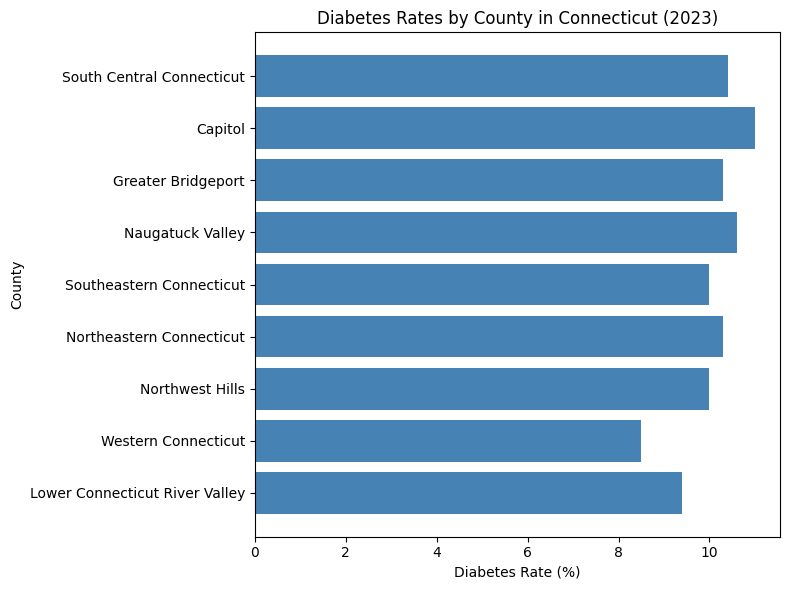

In [26]:
# CT Diabetes by County

import matplotlib.pyplot as plt

latest_year = diabetes["year"].max()

ct_latest = diabetes[
    (diabetes["stateabbr"] == "CT") &
    (diabetes["measureid"] == "DIABETES") &
    (diabetes["year"] == latest_year)
]

ct_latest_sorted = ct_latest.sort_values(
    "diabetes_rate", ascending=True
)

plt.figure(figsize=(8,6))
plt.barh(
    ct_latest_sorted["locationname"],
    ct_latest_sorted["diabetes_rate"],
    color="steelblue"
)
plt.title(f"Diabetes Rates by County in Connecticut ({latest_year})")
plt.xlabel("Diabetes Rate (%)")
plt.ylabel("County")
plt.tight_layout()
plt.show()

In [ ]:
metrics = ["OBESITY", "DIABETES", "DEPRESSION"]

ct_metrics = diabetes[
    (diabetes["stateabbr"] == "CT") &
    (diabetes["measureid"].isin(metrics))
].groupby("measureid")["diabetes_rate"].mean()

us_metrics = diabetes[
    (obesity["measureid"].isin(metrics))
].groupby("measureid")["diabetes_rate"].mean()

df_compare = pd.DataFrame({
    "CT": ct_metrics,
    "US": us_metrics
})

df_compare.plot(kind="bar", figsize=(7,5))
plt.title("CT vs US — Health Indicator Comparison")
plt.ylabel("Average Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df_compare

# Mental Health

In [28]:
def load_parquet_mentalhealth():
    path = os.path.join(DATA_DIR, "mental_health_all_years.parquet")
    print("Loading:", path)
    df = pd.read_parquet(path)
    return df

mentalhealth = load_parquet_mentalhealth()
mentalhealth.head()

Loading: /Users/mgrsuraz/Downloads/Courses/DSDE/Project_Final/Health_project/processed_data/mental_health_all_years.parquet


,year,stateabbr,statedesc,locationname,measureid,mhlth_rate,totalpopulation,latitude,longitude,data_value_type
0,2023,NE,Nebraska,Greeley,MHLTH,15.6,2219,41.567435,-98.521451,Age-adjusted prevalence
1,2023,MO,Missouri,Sullivan,MHLTH,17.7,5797,40.210683,-93.111670,Crude prevalence
2,2023,MO,Missouri,Stoddard,MHLTH,19.0,28397,36.855640,-89.944450,Crude prevalence
3,2023,MO,Missouri,Carter,MHLTH,21.5,5303,36.941187,-90.962185,Age-adjusted prevalence
4,2023,NE,Nebraska,Chase,MHLTH,13.1,3724,40.523710,-101.697941,Crude prevalence


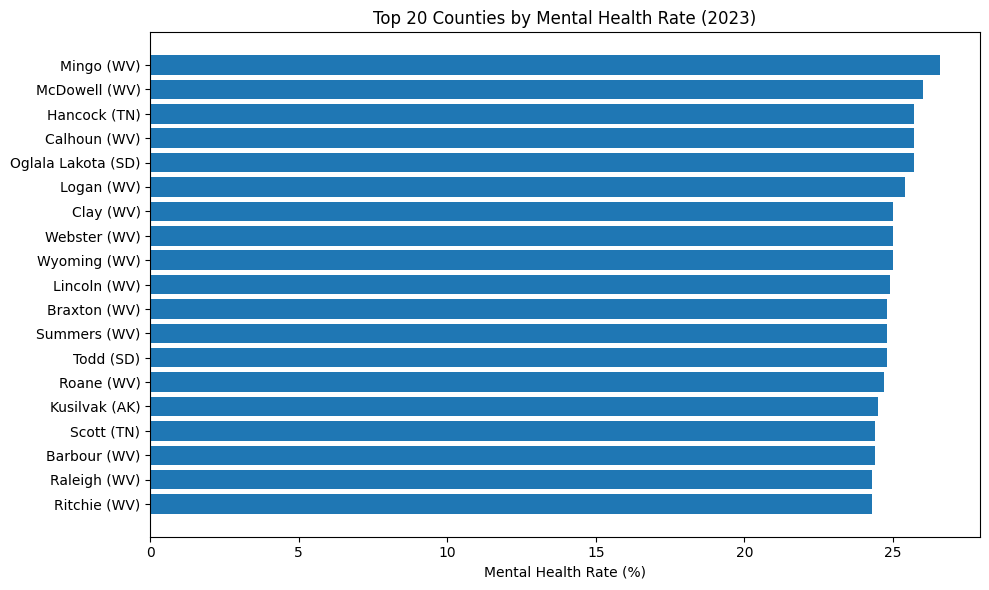

In [29]:
latest_year = mentalhealth["year"].max()
latest_df = mentalhealth[mentalhealth["year"] == latest_year]

top20 = (
    latest_df
    .sort_values("mhlth_rate", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
plt.barh(top20["locationname"] + " (" + top20["stateabbr"] + ")", top20["mhlth_rate"])
plt.gca().invert_yaxis()
plt.xlabel("Mental Health Rate (%)")
plt.title(f"Top 20 Counties by Mental Health Rate ({latest_year})")
plt.tight_layout()
plt.show()

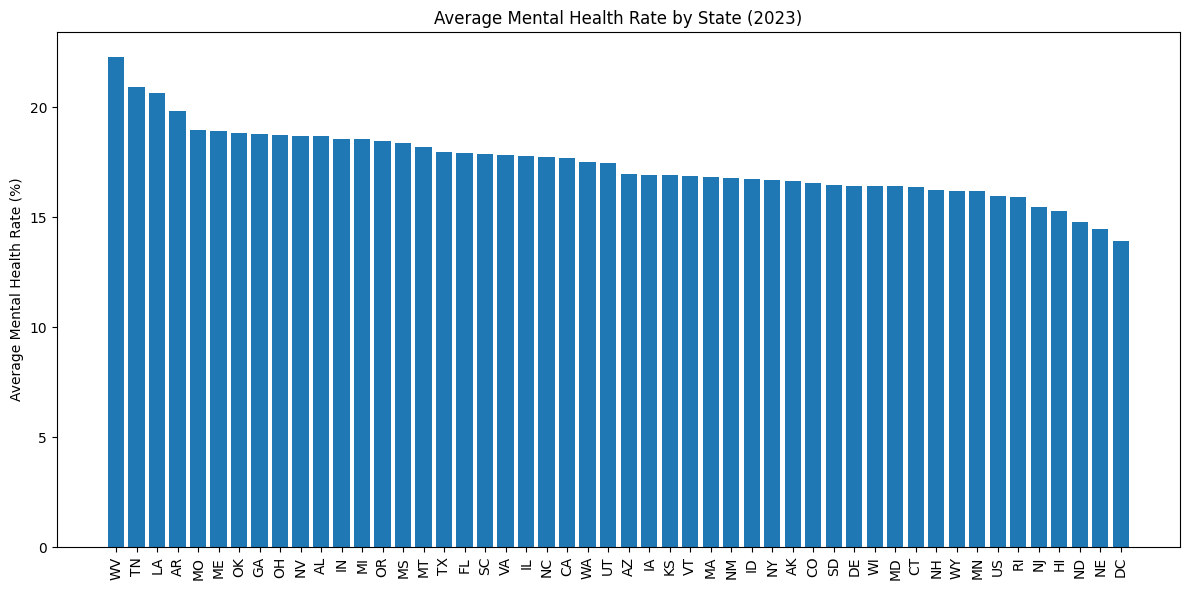

In [30]:
state_avg = (
    latest_df
    .groupby(["stateabbr", "statedesc"], as_index=False)
    .agg(
        mean_mhlth=("mhlth_rate", "mean"),
        pop=("totalpopulation", "sum")
    )
)

state_avg_sorted = state_avg.sort_values("mean_mhlth", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(state_avg_sorted["stateabbr"], state_avg_sorted["mean_mhlth"])
plt.xticks(rotation=90)
plt.ylabel("Average Mental Health Rate (%)")
plt.title(f"Average Mental Health Rate by State ({latest_year})")
plt.tight_layout()
plt.show()



/var/folders/nw/57_fjtfx1n3515btxc1rjzyh0000gn/T/ipykernel_31480/2227360106.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_mhlth["weighted_mhlth"] = (


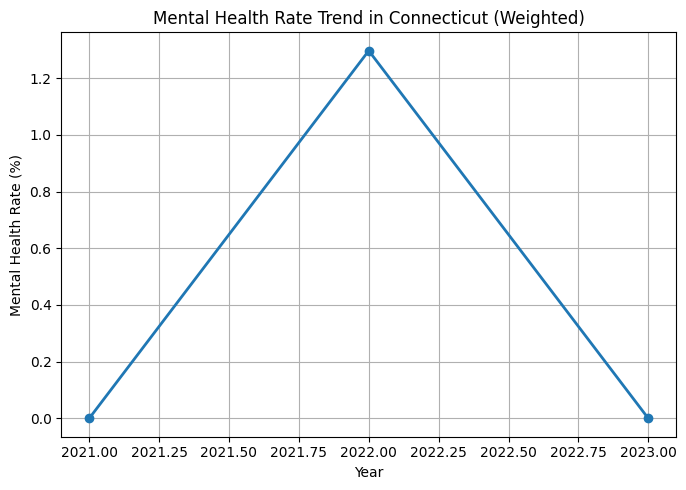

,year,total_weighted,total_pop,ct_mhlth_rate
0,2021,0.0,7211194,0.000000
1,2022,9405909.4,7252410,1.296936
2,2023,0.0,7234352,0.000000


In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for Connecticut + Mental Health only
ct_mhlth = mentalhealth[
    (mentalhealth["stateabbr"] == "CT") &
    (mentalhealth["measureid"] == "MHLTH")
]

# Compute statewide population-weighted mental health per year
ct_mhlth["weighted_mhlth"] = (
    ct_mhlth["mhlth_rate"] * ct_obesity["totalpopulation"]
)

ct_trend = (
    ct_mhlth.groupby("year", as_index=False)
    .agg(
        total_weighted=("weighted_mhlth", "sum"),
        total_pop=("totalpopulation", "sum"),
    )
)

ct_trend["ct_mhlth_rate"] = (
    ct_trend["total_weighted"] / ct_trend["total_pop"]
)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(
    ct_trend["year"], 
    ct_trend["ct_mhlth_rate"], 
    marker="o", linewidth=2
)
plt.title("Mental Health Rate Trend in Connecticut (Weighted)")
plt.xlabel("Year")
plt.ylabel("Mental Health Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

ct_trend


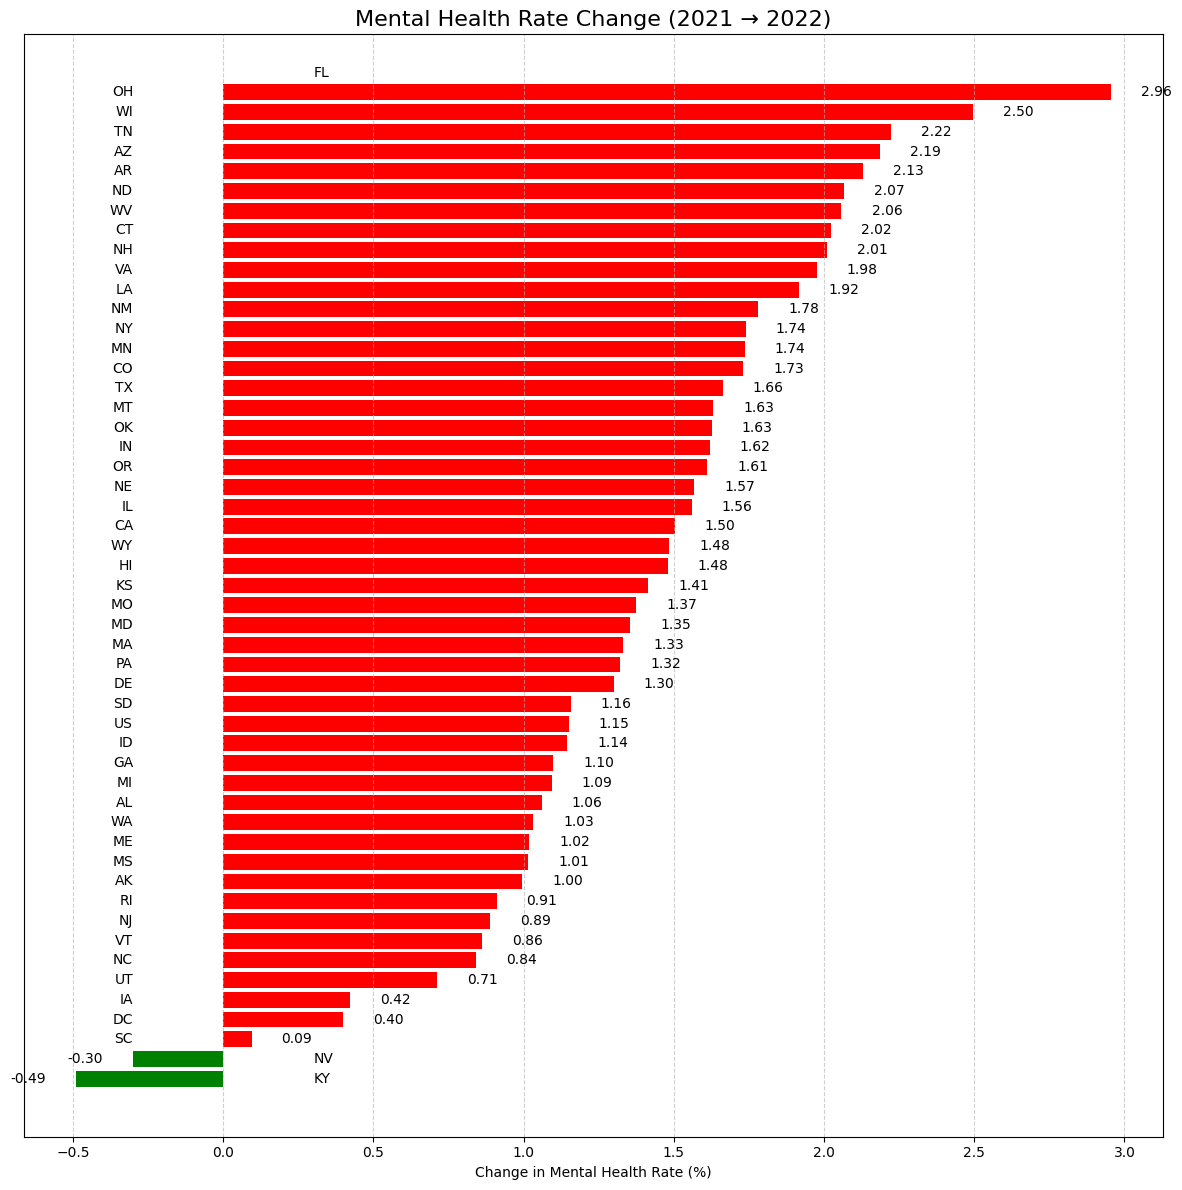

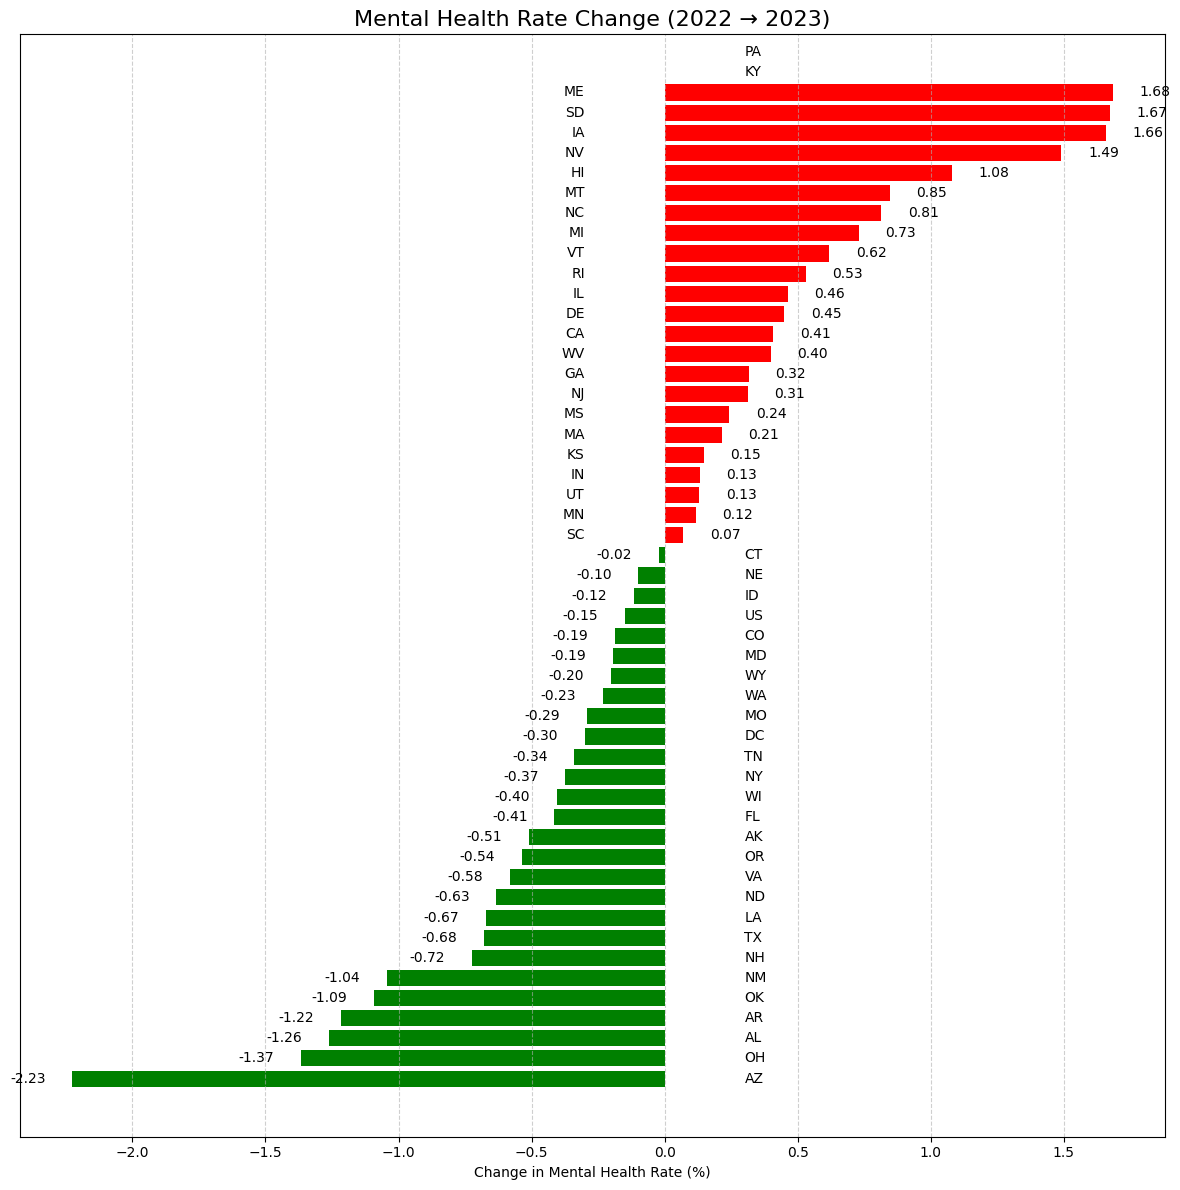

In [32]:
ob = mentalhealth[mentalhealth["measureid"] == "MHLTH"]

state_year_avg = (
    ob.groupby(["stateabbr", "year"])["mhlth_rate"]
      .mean()
      .reset_index()
)

state_pivot = state_year_avg.pivot(
    index="stateabbr",
    columns="year",
    values="mhlth_rate"
).reset_index()

state_pivot.head()

state_pivot["change_2021_2022"] = state_pivot[2022] - state_pivot[2021]
state_pivot["change_2022_2023"] = state_pivot[2023] - state_pivot[2022]

import matplotlib.pyplot as plt
import numpy as np

def plot_change(df, col, title):
    df_sorted = df.sort_values(col)
    values = df_sorted[col].values
    states = df_sorted["stateabbr"].values

    colors = np.where(values >= 0, "red", "green")

    plt.figure(figsize=(12,12))
    bars = plt.barh(
        range(len(values)),
        values,
        color=colors
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel("Change in Mental Health Rate (%)")
    plt.yticks([])
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    for i, (v, st) in enumerate(zip(values, states)):
        
        # Place STATE ABBREV 
        if v >= 0:
            # positive bar: put state on left side of bar start
            plt.text(
                0 - 0.3,      
                i,
                st,
                va="center",
                ha="right",
                fontsize=10,
            )
        else:
            # negative bar: put state on right side of zero line
            plt.text(
                0 + 0.3,
                i,
                st,
                va="center",
                ha="left",
                fontsize=10,
            )

        # Place CHANGE VALUE 
        plt.text(
            v + (0.1 if v >= 0 else -0.1), 
            i,
            f"{v:.2f}", 
            va="center",
            ha="left" if v >= 0 else "right",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


plot_change(state_pivot, "change_2021_2022", "Mental Health Rate Change (2021 → 2022)")
plot_change(state_pivot, "change_2022_2023", "Mental Health Rate Change (2022 → 2023)")



In [ ]:
# Find Which Connecticut County Has the Highest Mental Health Rate

latest_year = mentalhealth["year"].max()

ct_latest = mentalhealth[
    (mentalhealth["stateabbr"] == "CT") &
    (mentalhealth["measureid"] == "MHLTH") &
    (mentalhealth["year"] == latest_year)
]

# Sort highest to lowest
highest_ct_county = ct_latest.sort_values(
    "mhlth_rate", ascending=False
).head(1)

print("County with highest mental health in CT:")
print(highest_ct_county[["locationname", "mhlth_rate", "totalpopulation"]])


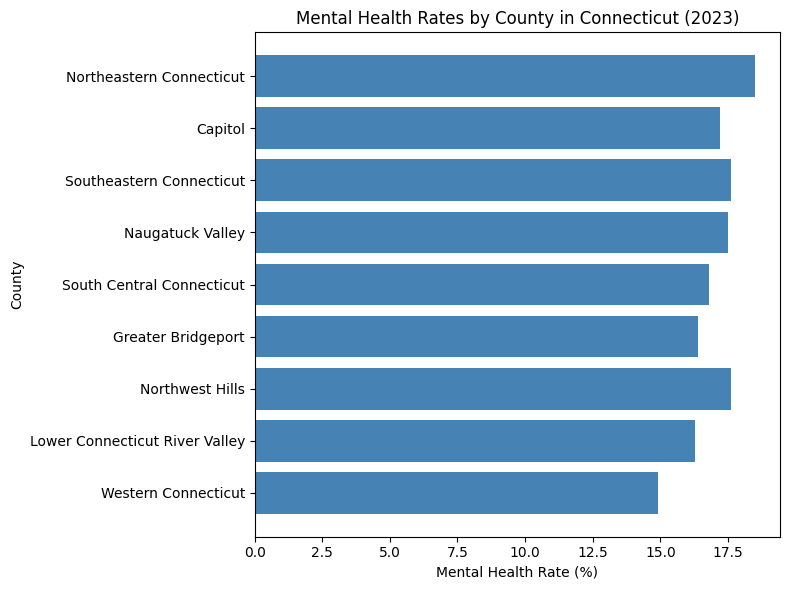

In [33]:
# CT Mental Health by County

import matplotlib.pyplot as plt

latest_year = mentalhealth["year"].max()

ct_latest = mentalhealth[
    (mentalhealth["stateabbr"] == "CT") &
    (mentalhealth["measureid"] == "MHLTH") &
    (mentalhealth["year"] == latest_year)
]

ct_latest_sorted = ct_latest.sort_values(
    "mhlth_rate", ascending=True
)

plt.figure(figsize=(8,6))
plt.barh(
    ct_latest_sorted["locationname"],
    ct_latest_sorted["mhlth_rate"],
    color="steelblue"
)
plt.title(f"Mental Health Rates by County in Connecticut ({latest_year})")
plt.xlabel("Mental Health Rate (%)")
plt.ylabel("County")
plt.tight_layout()
plt.show()

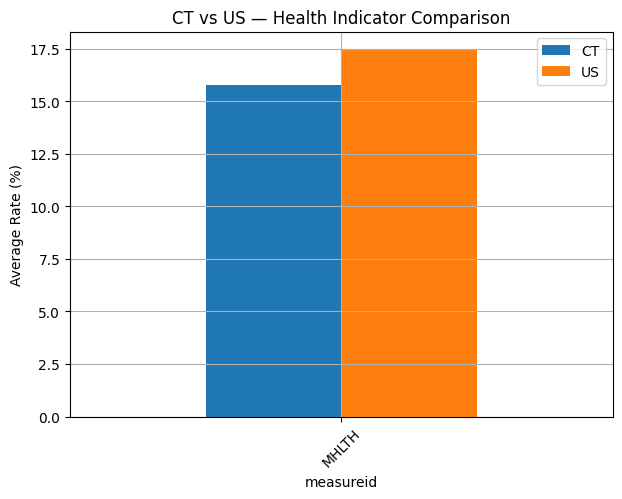

,CT,US
measureid,,
MHLTH,15.780769,17.457926


In [34]:
metrics = ["MHLTH","DEPRESSION"]

ct_metrics = mentalhealth[
    (mentalhealth["stateabbr"] == "CT") &
    (mentalhealth["measureid"].isin(metrics))
].groupby("measureid")["mhlth_rate"].mean()

us_metrics = mentalhealth[
    (mentalhealth["measureid"].isin(metrics))
].groupby("measureid")["mhlth_rate"].mean()

df_compare = pd.DataFrame({
    "CT": ct_metrics,
    "US": us_metrics
})

df_compare.plot(kind="bar", figsize=(7,5))
plt.title("CT vs US — Health Indicator Comparison")
plt.ylabel("Average Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df_compare


# Sleep

In [35]:
def load_parquet_sleep():
    path = os.path.join(DATA_DIR, "sleep_all_years.parquet")
    print("Loading:", path)
    df = pd.read_parquet(path)
    return df

sleep = load_parquet_sleep()
sleep.head()

Loading: /Users/mgrsuraz/Downloads/Courses/DSDE/Project_Final/Health_project/processed_data/sleep_all_years.parquet


,year,stateabbr,statedesc,locationname,measureid,sleep_rate,totalpopulation,latitude,longitude,data_value_type
0,2022,MO,Missouri,Johnson,SLEEP,38.5,54962,38.744205,-93.806351,Age-adjusted prevalence
1,2022,MT,Montana,Treasure,SLEEP,30.6,772,46.211418,-107.271842,Age-adjusted prevalence
2,2022,MT,Montana,Powell,SLEEP,34.4,7133,46.856599,-112.936298,Crude prevalence
3,2022,MT,Montana,Big Horn,SLEEP,36.2,12751,45.423301,-107.489444,Crude prevalence
4,2022,MO,Missouri,Clark,SLEEP,41.5,6641,40.410289,-91.738206,Age-adjusted prevalence


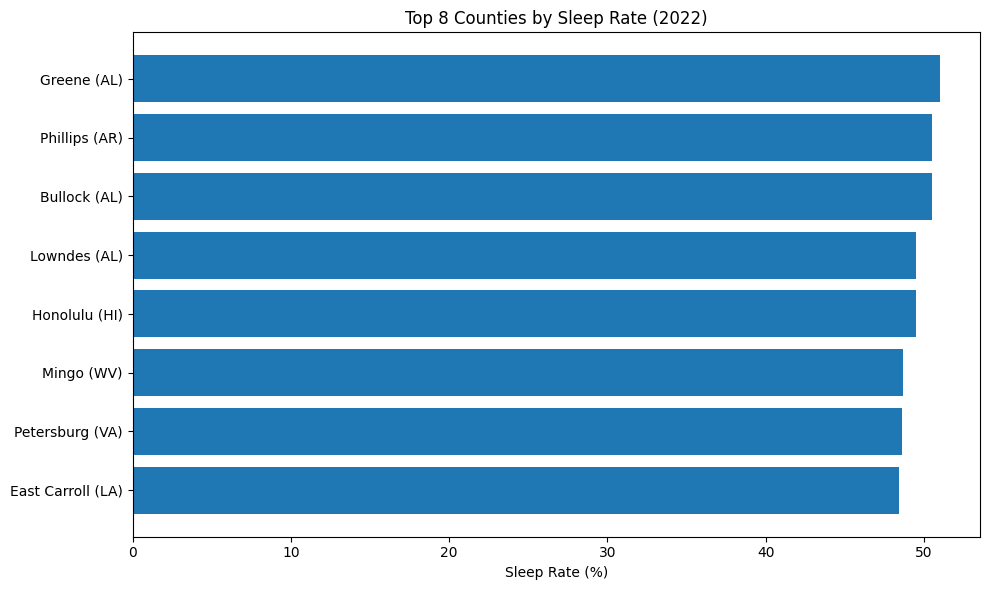

In [36]:
latest_year = sleep["year"].max()
latest_df = sleep[sleep["year"] == latest_year]

top20 = (
    latest_df
    .sort_values("sleep_rate", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
plt.barh(top20["locationname"] + " (" + top20["stateabbr"] + ")", top20["sleep_rate"])
plt.gca().invert_yaxis()
plt.xlabel("Sleep Rate (%)")
plt.title(f"Top 8 Counties by Sleep Rate ({latest_year})")
plt.tight_layout()
plt.show()


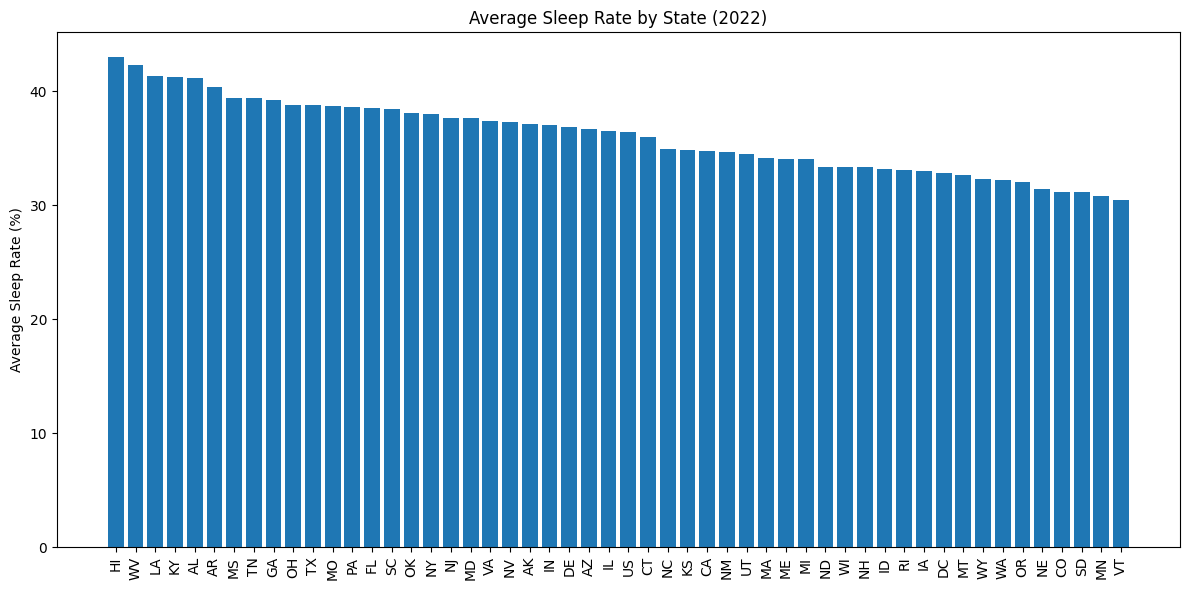

In [37]:
state_avg = (
    latest_df
    .groupby(["stateabbr", "statedesc"], as_index=False)
    .agg(
        mean_sleep=("sleep_rate", "mean"),
        pop=("totalpopulation", "sum")
    )
)

state_avg_sorted = state_avg.sort_values("mean_sleep", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(state_avg_sorted["stateabbr"], state_avg_sorted["mean_sleep"])
plt.xticks(rotation=90)
plt.ylabel("Average Sleep Rate (%)")
plt.title(f"Average Sleep Rate by State ({latest_year})")
plt.tight_layout()
plt.show()

/var/folders/nw/57_fjtfx1n3515btxc1rjzyh0000gn/T/ipykernel_31480/3134800332.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_sleep["weighted_sleep"] = (


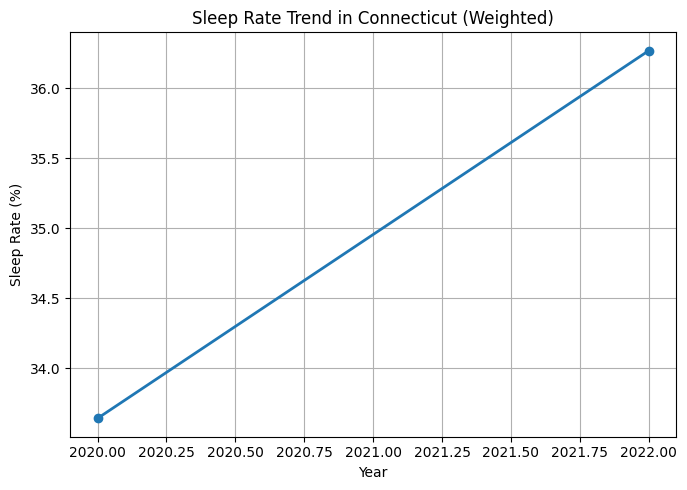

,year,total_weighted,total_pop,ct_sleep_rate
0,2020,242612814.4,7211194,33.643917
1,2022,525417274.1,14486762,36.268786


In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for Connecticut + sleep only
ct_sleep = sleep[
    (sleep["stateabbr"] == "CT") &
    (sleep["measureid"] == "SLEEP")
]

# Compute statewide population-weighted sleep per year
ct_sleep["weighted_sleep"] = (
    ct_sleep["sleep_rate"] * ct_sleep["totalpopulation"]
)

ct_trend = (
    ct_sleep.groupby("year", as_index=False)
    .agg(
        total_weighted=("weighted_sleep", "sum"),
        total_pop=("totalpopulation", "sum"),
    )
)

ct_trend["ct_sleep_rate"] = (
    ct_trend["total_weighted"] / ct_trend["total_pop"]
)

plt.figure(figsize=(7, 5))
plt.plot(
    ct_trend["year"], 
    ct_trend["ct_sleep_rate"], 
    marker="o", linewidth=2
)
plt.title("Sleep Rate Trend in Connecticut (Weighted)")
plt.xlabel("Year")
plt.ylabel("Sleep Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

ct_trend

In [39]:
latest_year = sleep["year"].max()

ct_latest = sleep[
    (sleep["stateabbr"] == "CT") &
    (sleep["measureid"] == "SLEEP") &
    (sleep["year"] == latest_year)
]

# Sort highest to lowest
highest_ct_county = ct_latest.sort_values(
    "sleep_rate", ascending=False
).head(1)

print("County with highest sleep in CT:")
print(highest_ct_county[["locationname", "sleep_rate", "totalpopulation"]])


County with highest sleep in CT:
                  locationname  sleep_rate  totalpopulation
8356  Southeastern Connecticut        38.5           279634


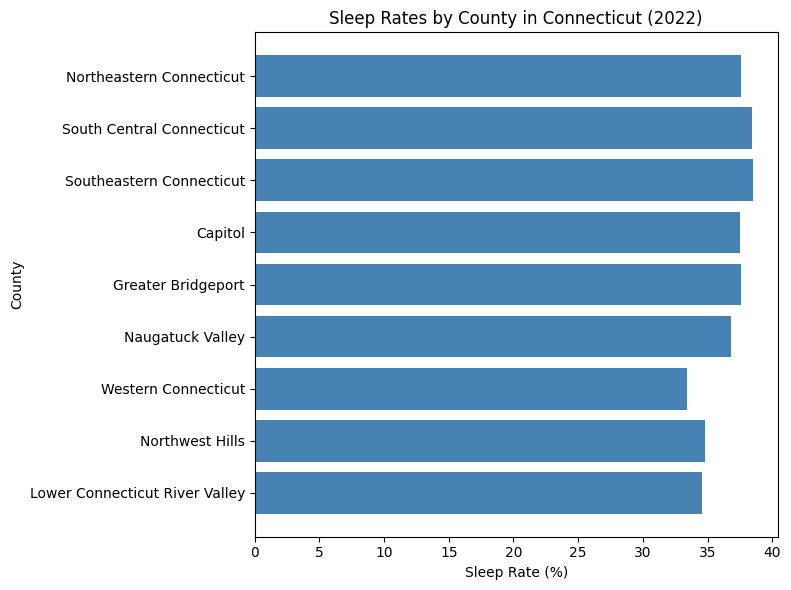

In [40]:
# CT Sleep by County

import matplotlib.pyplot as plt

latest_year = sleep["year"].max()

ct_latest = sleep[
    (sleep["stateabbr"] == "CT") &
    (sleep["measureid"] == "SLEEP") &
    (sleep["year"] == latest_year)
]

ct_latest_sorted = ct_latest.sort_values(
    "sleep_rate", ascending=True
)

plt.figure(figsize=(8,6))
plt.barh(
    ct_latest_sorted["locationname"],
    ct_latest_sorted["sleep_rate"],
    color="steelblue"
)
plt.title(f"Sleep Rates by County in Connecticut ({latest_year})")
plt.xlabel("Sleep Rate (%)")
plt.ylabel("County")
plt.tight_layout()
plt.show()

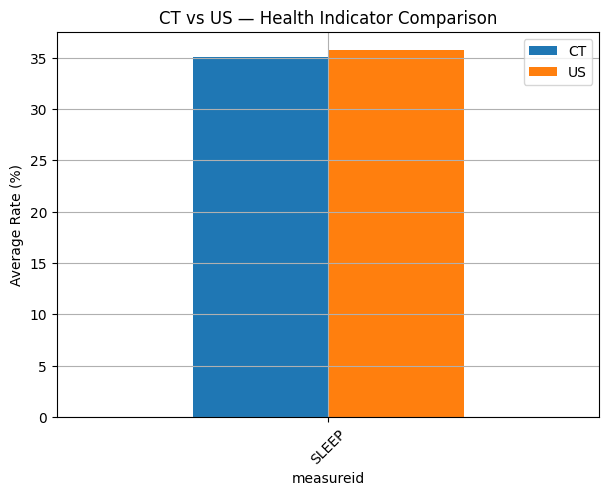

,CT,US
measureid,,
SLEEP,35.113462,35.746915


In [41]:
metrics = ["SLEEP", "DIABETES", "DEPRESSION"]

ct_metrics = sleep[
    (sleep["stateabbr"] == "CT") &
    (sleep["measureid"].isin(metrics))
].groupby("measureid")["sleep_rate"].mean()

us_metrics = sleep[
    (sleep["measureid"].isin(metrics))
].groupby("measureid")["sleep_rate"].mean()

df_compare = pd.DataFrame({
    "CT": ct_metrics,
    "US": us_metrics
})

df_compare.plot(kind="bar", figsize=(7,5))
plt.title("CT vs US — Health Indicator Comparison")
plt.ylabel("Average Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df_compare